D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30690 (\N{CJK UNIFIED IDEOGRAPH-77E2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20999 (\N{CJK UNIFIED IDEOGRAPH-5207}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing f

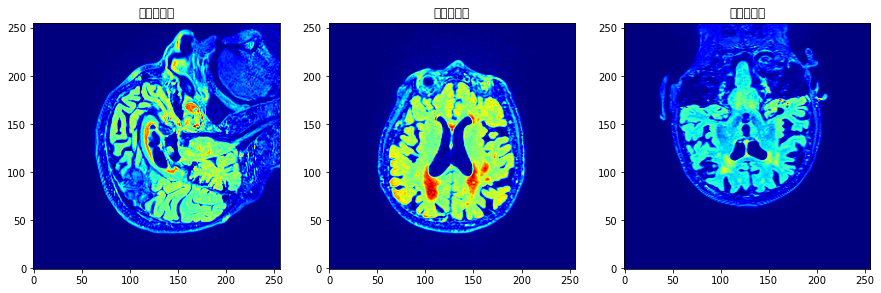

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Load the NIfTI file
file_path = r'D:\Work\Medical image\Sagittal_3D_FLAIR\Processed\ADNI_003_S_1074_MR_Sagittal_3D_FLAIR__br_raw_20170929151143755_43_S615872_I912464-test.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

# Obtain the indices of the middle slice
slice_x = image_data.shape[0] // 2
slice_y = image_data.shape[1] // 2
slice_z = image_data.shape[2] // 2

# Extract the slices
slice_0 = image_data[slice_x, :, :]
slice_1 = image_data[:, slice_y, :]
slice_2 = image_data[:, :, slice_z]

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(slice_0.T, cmap='jet', origin="lower")
axes[0].set_title('Sagittal Slice')

axes[1].imshow(slice_1.T, cmap='jet', origin="lower")
axes[1].set_title('Coronal Slice')

axes[2].imshow(slice_2.T, cmap='jet', origin="lower")
axes[2].set_title('Axial Slice')

# Display the images
plt.show()


D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38646 (\N{CJK UNIFIED IDEOGRAPH-96F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing f

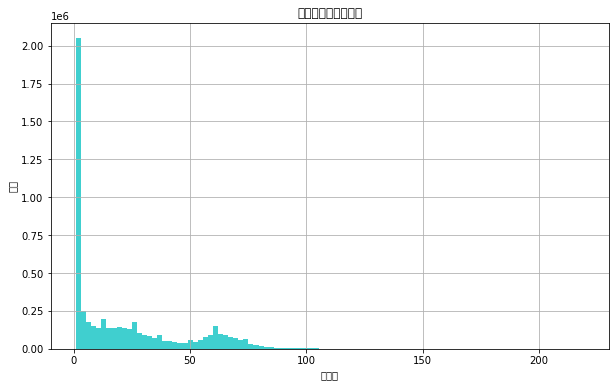

In [2]:
# Retrieve non-zero pixel values
non_zero_values = image_data[image_data > 0]

# Plot the distribution of non-zero pixel values
plt.figure(figsize=(10, 6))
plt.hist(non_zero_values.ravel(), bins=100, color='c', alpha=0.75)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Non-Zero Pixel Values')
plt.grid(True)
plt.show()


In [4]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18

# Check cuda availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Use a pre-built 3D ResNet model
model = r3d_18(pretrained=True, progress=True)
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3)

model = model.to(device)

class SEBlock(nn.Module):
    def __init__(self, input_dim, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim // reduction, input_dim, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)

# Integrate the SE module into each BasicBlock of the ResNet
for name, module in model.named_modules():
    if isinstance(module, nn.Sequential):
        for child_name, child_module in module.named_children():
            if hasattr(child_module, 'bn2'):  # Confirm the existence of bn2
                setattr(child_module, 'se_block', SEBlock(child_module.bn2.num_features))


def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    
    # Attention mechanism part
    out = self.se_block(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out


In [17]:
import os
import numpy as np
import nibabel as nib

# Directory path
folder_path = 'D:\\Work\\Medical image\\Sagittal_3D_FLAIR\\Processed'

# Read .nii files and stack them into a list
data_list = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.nii'):
        file_path = os.path.join(folder_path, file_name)
        image = nib.load(file_path)
        image_data = image.get_fdata()
        # Ensure the image is three-dimensional and add a new axis to represent a single channel
        if image_data.ndim == 3:
            image_data = image_data[np.newaxis, ...]  # Add single-channel dimension
        data_list.append(image_data)

# Stack the data in the list into a large NumPy array
# Assuming the size of each image is the same
data = np.vstack(data_list)
# At this point, the shape of data should be (n_samples, 1, depth, height, width)
data = data[:, np.newaxis, ...]
print(f'data shape: {data.shape}')


data shape: (8, 1, 256, 256, 256)


In [14]:
import os
import pandas as pd

# Path to the CSV file
csv_file_path = 'D:\\Work\\Medical image\\Sagittal_3D_FLAIR\\Sagittal_3D_FLAIR_4_14_2023.csv'
# Path to the directory
folder_path = 'D:\\Work\\Medical image\\Sagittal_3D_FLAIR\\Processed'

# Read the CSV file
labels_df = pd.read_csv(csv_file_path)

# Create a dictionary mapping Subject to Group
label_dict = pd.Series(labels_df.Group.values, index=labels_df.Subject).to_dict()

# Read .nii files and generate labels for each file
labels = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.nii'):
        # Assuming the file name contains the Subject number, and it is at the start of the file name
        subject_number = file_name.split('_')[1]+'_'+file_name.split('_')[2]+'_'+file_name.split('_')[3]
        # Get the corresponding Group as a label
        label = label_dict.get(subject_number)
        if label is not None:
            labels.append(label)

# Convert labels to a NumPy array (if needed)
labels_array = np.array(labels[:8])

print(f'Labels: {labels_array}')


Labels: ['MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'CN' 'EMCI']


In [15]:
# Create an empty list to store the new integer labels
int_labels = []

# Define the mapping rule
label_mapping = {'CN': 0, 'AD': 2, 'MCI': 1, 'EMCI': 1}

# Iterate through labels_array and apply the mapping rule
for label in labels_array:
    int_label = label_mapping.get(label, -1)  # Use -1 as the default value when no match is found
    int_labels.append(int_label)

# Convert the list of integer labels to a NumPy array
int_labels_array = np.array(int_labels)

print(f'Integer Labels Array: {int_labels_array}')

Integer Labels Array: [1 1 0 0 1 1 0 1]


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming 'data' and 'labels' are numpy arrays
# Convert data and labels to PyTorch tensors and move them to the GPU if available
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)

# Create a dataset from tensors
dataset = TensorDataset(data_tensor, labels_tensor)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model, loss function, and optimizer initialization remains the same
model = model.to(device)  # Ensure model is on the same device
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class problems
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print loss for each epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print results on validation set
    print(f'Validation Loss: {val_loss / len(val_loader)}')
    print(f'Validation Accuracy: {100 * correct / total}%')

# Save model weights
torch.save(model.state_dict(), 'model_weights.pth')  # Updated file path


Epoch 1, Loss: 1.1456564962863922
Validation Loss: 5.440985679626465
Validation Accuracy: 0.0%
Epoch 2, Loss: 1.0038465559482574
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 3, Loss: 1.022882878780365
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 4, Loss: 0.9198742210865021
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 5, Loss: 0.6482399702072144
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 6, Loss: 0.5924766063690186
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 7, Loss: 0.5322147607803345
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 8, Loss: 0.7665224075317383
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 9, Loss: 0.3801499903202057
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 10, Loss: 0.325473353266716
Validation Loss: 0.0
Validation Accuracy: 100.0%
Epoch 11, Loss: 0.3690948635339737
Validation Loss: 1.1920927533992653e-07
Validation Accuracy: 100.0%
Epoch 12, Loss: 0.5296418517827988
Validation Loss: 0.0



KeyboardInterrupt



In [5]:
weights_path = r'D:\Work\Medical image\Sagittal_3D_FLAIR\model_weights.pth'
model.load_state_dict(torch.load(weights_path))
model.eval()

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):